In [19]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

In [17]:
def Fr(w, p1, q1, p2, q2):
    cond_1 = w <= -2 * q2 / p2
    expr_1 = p2 * w + q2
    cond_2 = w <= 0
    expr_2 = - p2 ** 2 / (4 * q2) * w ** 2
    cond_3 = w <= 2 * q1 / p1
    expr_3 = p1 ** 2 / (4 * q1) * w ** 2
    cond_4 = True
    expr_4 = p1 * w - q1

    if cond_1:
        return expr_1
    elif cond_2:
        return expr_2
    elif cond_3:
        return expr_3
    elif cond_4:
        return expr_4

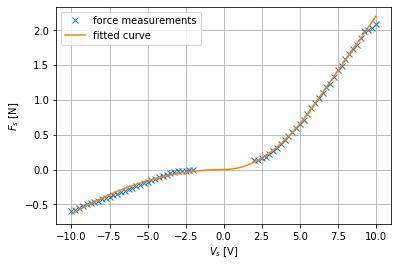

In [29]:
matfile = loadmat('../matlab/rotor_force_analysis/data_for_python')
vsfs_data = matfile['combined_normalized_data']
p1 = float(matfile['p1_opt'])
q1 = float(matfile['q1_opt'])
p2 = float(matfile['p2_opt'])
q2 = float(matfile['q2_opt'])

vs_plot = np.linspace(-10, 10, 101)
Fs_plot = np.array([Fr(vs, p1, q1, p2, q2) for vs in vs_plot])

plt.figure()
plt.plot(vsfs_data[:, 0], vsfs_data[:, 1], 'x', label='force measurements')
plt.plot(vs_plot, Fs_plot, label='fitted curve')
plt.legend()
plt.grid()
plt.xlabel('$V_s$ [V]')
plt.ylabel('$F_s$ [N]')

plt.savefig('force_curve.pdf')
plt.show()